# Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



In [95]:
import numpy as np
import typing

In [96]:
import pandas as pd
import requests
import zipfile
import io, os

# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}
meta_id = 622

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df

# Przykladowe użycie
#df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])

# Zad 1

In [97]:
def process_raw_df(dataframe: pd.DataFrame, year: int) -> pd.DataFrame:
    df = dataframe 
    if year == 2014: #ustlamy odpowiednie nazwy kolumn, usuwamy metadane o pomiarach, plik z 2014 ma inny format.
        df.columns = df.iloc[0]
        df = df.drop([0,1,2])
    else: 
        df.columns = df.iloc[1]
        df = df.drop([0,1,2,3,4,5])
        
    df['Measurment'] = pd.to_datetime(df.iloc[:,0])  # pierwsza kolumna -> datetime
    df = df.set_index('Measurment')
    df = df.drop(columns="Kod stacji")
    df = df.apply(pd.to_numeric, errors='coerce') # zmieniamy object -> float
    
    midn_mask = df.index.hour == 0 
    corrected_dates = df.index[midn_mask] - pd.Timedelta(seconds=1) #wszystkie wartości z północą przesuwamy o sekunde mniej

    df.index.values[midn_mask] = corrected_dates
    df = df.interpolate(method='time') #interpolujemy brakujące wartości

    return df

In [98]:
def process_metadata(metadata: pd.DataFrame) -> pd.DataFrame:
    old = 'Stary Kod stacji \n(o ile inny od aktualnego)'
    new = 'Kod stacji'
    #Niektóre wartości w metadanych to " " puste znaki, zamieniamy je na właściwe NaN
    met_old_station = metadata[old].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})
    met_new_station = metadata[new].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})
    metadata[old] = met_old_station
    metadata[new] = met_new_station
    #bierzemy pod uwage te wiersze gdzie zaszła zmiana kodów
    metadata = metadata.dropna(subset=[old, new])
    return metadata

In [99]:
def atomize_dict(mapper: dict[str, str]) -> dict[str, str]:
    dedup_station_map = {}
    for old_val, new_val in mapper.items():
        # Niektóre wartości rozdzielone "," np. ZpSzczecin002, ZpSzczPils02. Atomizujemy nasz dataframe.
        if old_val and ',' in old_val:
            old_codes = [code.strip() for code in str(old_val).split(',')]
            for code in old_codes:
                dedup_station_map[code] = new_val
        else:
            dedup_station_map[old_val] = new_val
    return dedup_station_map

In [100]:
def update_codes(df: pd.DataFrame, mapper: dict[str,str]) -> pd.DataFrame:
    # Używamy get, niektórych stacje, które nie zmieniały nazwy nie ma w naszym mapperze.
    df.columns = [mapper.get(col, col) for col in df.columns]
    return df

In [101]:
dfs = {}
years = [2014,2019,2024]
for year in years:
    dataframe = download_gios_archive(year, gios_url_ids[year], gios_pm25_file[year])
    print(f"Processing for {year}")
    dfs[year] = process_raw_df(dataframe, year)

/home/ejhuus/default/lib/python3.12/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Processing for 2014
Processing for 2019
Processing for 2024


In [102]:
old_station_name = 'Stary Kod stacji \n(o ile inny od aktualnego)'
new_station_name = 'Kod stacji'

In [103]:
#Pobieranie metadanych bezpośrednio do dataframe.
url = f"{gios_archive_url}{meta_id}"
response = requests.get(url)
metadata = pd.read_excel(io.BytesIO(response.content))

In [104]:
filtered_metadata = process_metadata(metadata)

In [105]:
#bierzemy pod uwage te wiersze gdzie zaszła zmiana kodów
metadata_subset = filtered_metadata.dropna(subset=[old_station_name, new_station_name])

In [106]:
raw_mapper = dict(zip(metadata_subset[old_station_name],metadata_subset[new_station_name]))

In [107]:
code_mapper = atomize_dict(raw_mapper)

In [108]:
for year, df in dfs.items():
    dfs[year] = update_codes(df, code_mapper)

In [109]:
#Zscalamy dataframe w jeden.
final_df = pd.concat(
    dfs.values(),
    axis=0,
    join="inner"
)

In [110]:
#Tworzymy multindex z tupli
station_cities = dict(zip(metadata['Kod stacji'], metadata['Miejscowość']))

final_df.columns = pd.MultiIndex.from_tuples(
    [(station_cities.get(code, 'Unknown'), code) for code in final_df.columns],
    names=['City', 'Station_Code']
)

In [111]:
final_df.to_csv("concat_df.csv")

In [112]:
final_df

City                     Wrocław    Bydgoszcz         Łódź       Zgierz  \
Station_Code        DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz   
Measurment                                                                
2014-01-01 01:00:00        152.0   116.214424    81.029259   119.696114   
2014-01-01 02:00:00        137.0   107.201928   210.364670    70.337502   
2014-01-01 03:00:00        129.0    98.189431    66.425789    40.915695   
2014-01-01 04:00:00        129.0    89.176935    53.999668    37.817917   
2014-01-01 05:00:00        105.0    80.164439    52.239670    38.814861   
...                          ...          ...          ...          ...   
2024-12-31 20:00:00         51.4     5.400000    33.300000    49.500000   
2024-12-31 21:00:00         65.5     7.700000    34.000000    48.700000   
2024-12-31 22:00:00         30.2    14.500000    31.700000    48.100000   
2024-12-31 23:00:00         36.0    15.100083    26.800000    38.400000   
2024-12-31 23:59:59         50.4    15.700000    37.300000    45.500000   

City                Zielona Góra       Kraków                 Legionowo  \
Station_Code        LuZielKrotka MpKrakAlKras MpKrakBulwar MzLegZegrzyn   
Measurment                                                                
2014-01-01 01:00:00          NaN        104.0         64.0        44.44   
2014-01-01 02:00:00          NaN        104.0         63.0       103.07   
2014-01-01 03:00:00          NaN         91.0         62.0        74.91   
2014-01-01 04:00:00          NaN         89.0         58.0        39.27   
2014-01-01 05:00:00          NaN         83.0         55.0        26.51   
...                          ...          ...          ...          ...   
2024-12-31 20:00:00         15.9         57.0         43.2        22.20   
2024-12-31 21:00:00         16.1         58.7         54.1        34.50   
2024-12-31 22:00:00         15.9         67.9         55.8        32.20   
2024-12-31 23:00:00         12.5         75.3         69.5        30.80   
2024-12-31 23:59:59         14.7         75.5         72.6        30.30   

City                       Płock        Radom  ...     Żyrardów  \
Station_Code        MzPlocMiReja MzRadTochter  ... MzZyraRoosev   
Measurment                                     ...                
2014-01-01 01:00:00          NaN        58.67  ...          NaN   
2014-01-01 02:00:00          NaN        40.07  ...          NaN   
2014-01-01 03:00:00          NaN        32.72  ...          NaN   
2014-01-01 04:00:00          NaN        27.44  ...          NaN   
2014-01-01 05:00:00          NaN        28.01  ...          NaN   
...                          ...          ...  ...          ...   
2024-12-31 20:00:00         33.0        37.20  ...         27.3   
2024-12-31 21:00:00         29.4        34.60  ...         29.4   
2024-12-31 22:00:00         29.3        29.05  ...         30.4   
2024-12-31 23:00:00         27.9        23.50  ...         30.5   
2024-12-31 23:59:59         25.5        21.00  ...         27.9   

City                Kędzierzyn-Koźle     Przemyśl       Gdańsk     Katowice  \
Station_Code            OpKKozBSmial PkPrzemGrunw PmGdaLeczkow SlKatoKossut   
Measurment                                                                    
2014-01-01 01:00:00            115.0       48.175         58.4        104.0   
2014-01-01 02:00:00            134.0       33.747         28.5        107.0   
2014-01-01 03:00:00            137.0       30.622         27.0        114.0   
2014-01-01 04:00:00            137.0       28.642         28.7        108.0   
2014-01-01 05:00:00            136.0       27.781         25.7         88.0   
...                              ...          ...          ...          ...   
2024-12-31 20:00:00             18.6       19.700         11.2         20.3   
2024-12-31 21:00:00             22.9       19.300         14.0         20.1   
2024-12-31 22:00:00             25.6       17.400         15.8         27.3   
2024-12-31 

# Zad 2
## Średnie miesięczne + trend dla miast
Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

In [121]:
import matplotlib.pyplot as plt

monthly = (
    final_df
    .groupby([final_df.index.year, final_df.index.month], axis=0)
    .mean()
)
monthly.head()

/tmp/ipykernel_7604/885774810.py:5: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby([final_df.index.year, final_df.index.month], axis=0)


City                       Wrocław    Bydgoszcz         Łódź       Zgierz  \
Station_Code          DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz   
Measurment Measurment                                                       
2014       1             42.823251    32.502071    34.311253    31.363293   
           2             38.396581    50.311188    45.729585    46.417594   
           3             37.413293    39.841037    34.728510    37.464369   
           4             25.536113    19.492388    23.474251    18.584680   
           5             14.855511    11.812185    16.423432    10.790780   

City                  Zielona Góra       Kraków                 Legionowo  \
Station_Code          LuZielKrotka MpKrakAlKras MpKrakBulwar MzLegZegrzyn   
Measurment Measurment                                                       
2014       1             51.254277    60.350806    47.242608    39.863690   
           2             32.033483    86.711310    62.504464    62.753609   
           3             36.913982    54.515457    39.885753    46.000163   
           4             23.149305    35.060416    24.513889    27.777273   
           5             12.951613    19.362903    14.522849    14.040951   

City                         Płock        Radom  ...     Żyrardów  \
Station_Code          MzPlocMiReja MzRadTochter  ... MzZyraRoosev   
Measurment Measurment                            ...                
2014       1             31.318764    40.485457  ...    36.373062   
           2             50.473512    53.218289  ...    55.911123   
           3             31.589651    43.391626  ...    42.333058   
           4             20.859472    27.687528  ...    25.807070   
           5             12.079019    14.366935  ...    14.186102   

City                  Kędzierzyn-Koźle     Przemyśl       Gdańsk     Katowice  \
Station_Code              OpKKozBSmial PkPrzemGrunw PmGdaLeczkow SlKatoKossut   
Measurment Measurment                                                           
2014       1                 42.893811    32.047507    15.568078    48.284275   
           2                 41.872768    51.465929    26.489434    57.980652   
           3                 45.743280    30.242641    15.098253    42.875000   
           4                 27.166667    20.821891    13.423333    26.402778   
           5                 16.313844    10.376133    10.499194    14.885753   

City                   Złoty Potok      Olsztyn       Kalisz     Szczecin  \
Station_Code          SlZlotPotLes WmOlsPuszkin WpKaliSawick ZpSzczAndrze   
Measurment Measurment                                                       
2014       1             25.124993    26.145267    42.072878    31.243324   
           2             34.269354    40.799969    51.630807    22.693220   
           3             22.463699    24.900831    53.083400    26.966741   
           4             15.132643    17.748875    32.473612    15.956071   
           5              8.831317    13.577104    18.128231    10.897905   

City                                
Station_Code          ZpSzczPilsud  
Measurment Measurment               
2014       1             32.454301  
           2             32.040923  
           3             33.227148  
           4             22.127778  
           5             12.274866  

[5 rows x 23 columns]

In [122]:
# Przygotowanie danych do wykresu dla Warszawy i Katowic
monthly_cities = monthly.groupby(level='City', axis=1).mean()
cities_to_plot = ['Warszawa', 'Katowice']
years_to_plot = [2014, 2024]
trends_data = {}

for year in years_to_plot:
    for city in cities_to_plot:
        if city in monthly_cities.columns and year in monthly_cities.index.get_level_values(0):
            
            data_series = monthly_cities.loc[year, city]
            trends_data[(city, year)] = data_series

print("Dane do wykresu trendów dla Warszawy i Katowic:")
display(pd.DataFrame(trends_data).head())
display(pd.DataFrame(trends_data).tail())

Dane do wykresu trendów dla Warszawy i Katowic:


/tmp/ipykernel_7604/1917444633.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly_cities = monthly.groupby(level='City', axis=1).mean()


,Warszawa,Katowice,Warszawa,Katowice
,2014,2014,2024,2024
Measurment,,,,
1,30.054401,48.284275,19.154872,25.719624
2,42.768422,57.980652,14.845259,18.910776
3,34.836686,42.875000,20.426008,24.651210
4,24.713106,26.402778,12.054097,13.398333
5,17.448432,14.885753,9.655578,9.972447


,Warszawa,Katowice,Warszawa,Katowice
,2014,2014,2024,2024
Measurment,,,,
8,16.368724,11.441532,10.064180,11.948790
9,18.891338,22.597222,14.495694,13.956111
10,32.422442,35.278898,14.878596,16.799194
11,34.714086,42.026389,17.690694,22.538056
12,32.355825,47.022849,17.317070,30.312903


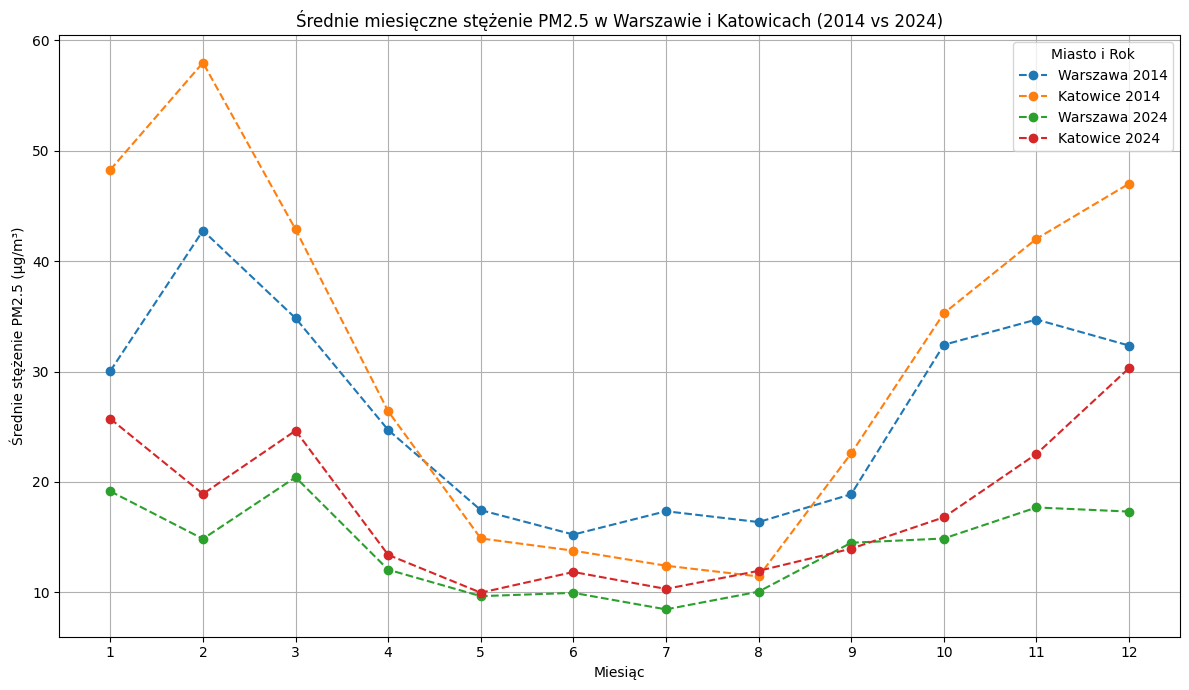

In [123]:
# Rysowanie wykresu trendów
fig, ax = plt.subplots(figsize=(12, 7))

for (city, year), data in trends_data.items():
    # Miesiące na osi X
    months = range(1, 13)
    ax.plot(months, data.values, marker='o', linestyle='--', label=f'{city} {year}')

# Ustawienia wykresu
ax.set_title('Średnie miesięczne stężenie PM2.5 w Warszawie i Katowicach (2014 vs 2024)')
ax.set_xlabel('Miesiąc')
ax.set_ylabel('Średnie stężenie PM2.5 (µg/m³)')
ax.set_xticks(months)
ax.legend(title='Miasto i Rok')
ax.grid(True)

plt.tight_layout()
plt.show()

## Interpretacja zadania 2-ego
Po pierwsze możemy zauważyć, że w niektórych miesiącach poziomy zanieczyszczeń są o wiele większe niż innych np. w okresach zimowych średnie stężenie PM2.5 (najwyższy odczyt w lutym) jest zauważalnie większe niż w okresie letnim. To oczywiście spowodowane jest paleniem min. w piecach w gospodarstwach domowych.
Co ciekawsze w latach 2014 ogólny średni poziom zanieczysczeń jest większy niż w latach 2024 (linie trendu są wyżej), możemy, więc zauważyć efekty przepisów mających na celu ochronę środowiska, a także wymianę min. starych pieców grzewczych na nowe.
Ostatnią sprawą może być to, że średni poziom PM2.5 jest mniejszy w Warszawie niżeli w Katowicach (być może spowodowane tym, że na Śląsku w gospodarstwach domowych więcej było pieców węglowych).


# Zad 3
## Heatmapa miesięcznych średnich
Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

In [125]:
all_dfs = []
for year, df in dfs.items():
    # Dodajemy kolumnę z rokiem
    df_year = df.copy()
    df_year['Year'] = year
    all_dfs.append(df_year.reset_index())

combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.set_index(['Measurment', 'Year'])

print("Informacje o połączonym DataFrame:")
combined_df

Informacje o połączonym DataFrame:


,,DsWrocAlWisn,KpWiktorowoG,KpBydPlPozna,KpBydWarszaw,KpToruDziewu,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBujaka,...,SlKatoPlebA4,SlRaciborzWPMOB,SlZywieKoper,WmDzialPolnaMOB,WmElkStadion,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew
Measurment,Year,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,2014,152.0,104.56,116.214424,140.857376,52.4172,81.029259,119.696114,NaN,104.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 02:00:00,2014,137.0,94.30,107.201928,121.629723,49.4912,210.364670,70.337502,NaN,104.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 03:00:00,2014,129.0,102.48,98.189431,59.189041,46.5652,66.425789,40.915695,NaN,91.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 04:00:00,2014,129.0,102.32,89.176935,58.038334,45.8128,53.999668,37.817917,NaN,89.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-01 05:00:00,2014,105.0,88.73,80.164439,59.658134,45.8128,52.239670,38.814861,NaN,83.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 20:00:00,2024,51.4,NaN,5.400000,34.100000,NaN,33.300000,49.500000,15.9,57.0,NaN,...,33.4,23.5,21.7,14.7,13.5,18.7,22.0,35.3,8.8,10.9
2024-12-31 21:00:00,2024,65.5,NaN,7.700000,34.600000,NaN,34.000000,48.700000,16.1,58.7,NaN,...,38.6,23.1,21.7,14.7,11.8,18.7,22.9,28.5,8.8,9.0
2024-12-31 22:00:00,2024,30.2,NaN,14.500000,29.300000,NaN,31.700000,48.100000,15.9,67.9,NaN,...,37.5,22.0,26.0,14.7,9.6,18.7,21.3,23.4,8.8,8.2


In [127]:
# Przekształcamy dane do formatu 'long' dla łatwiejszego grupowania
df_long = combined_df.stack(level=['City', 'Station_Code']).reset_index()
df_long.rename(columns={0: 'PM25_Value'}, inplace=True)

# Dodajemy kolumnę z miesiącem
df_long['Month'] = df_long['Measurment'].dt.month

# Grupujemy dane po mieście, roku i miesiącu, obliczając średnią
city_monthly_avg = df_long.groupby(['City', 'Year', 'Month'])['PM25_Value'].mean().reset_index()

print("Średnie miesięczne dla miast:")
display(city_monthly_avg.head())

ValueError: level should contain all level names or all level numbers, not a mixture of the two.

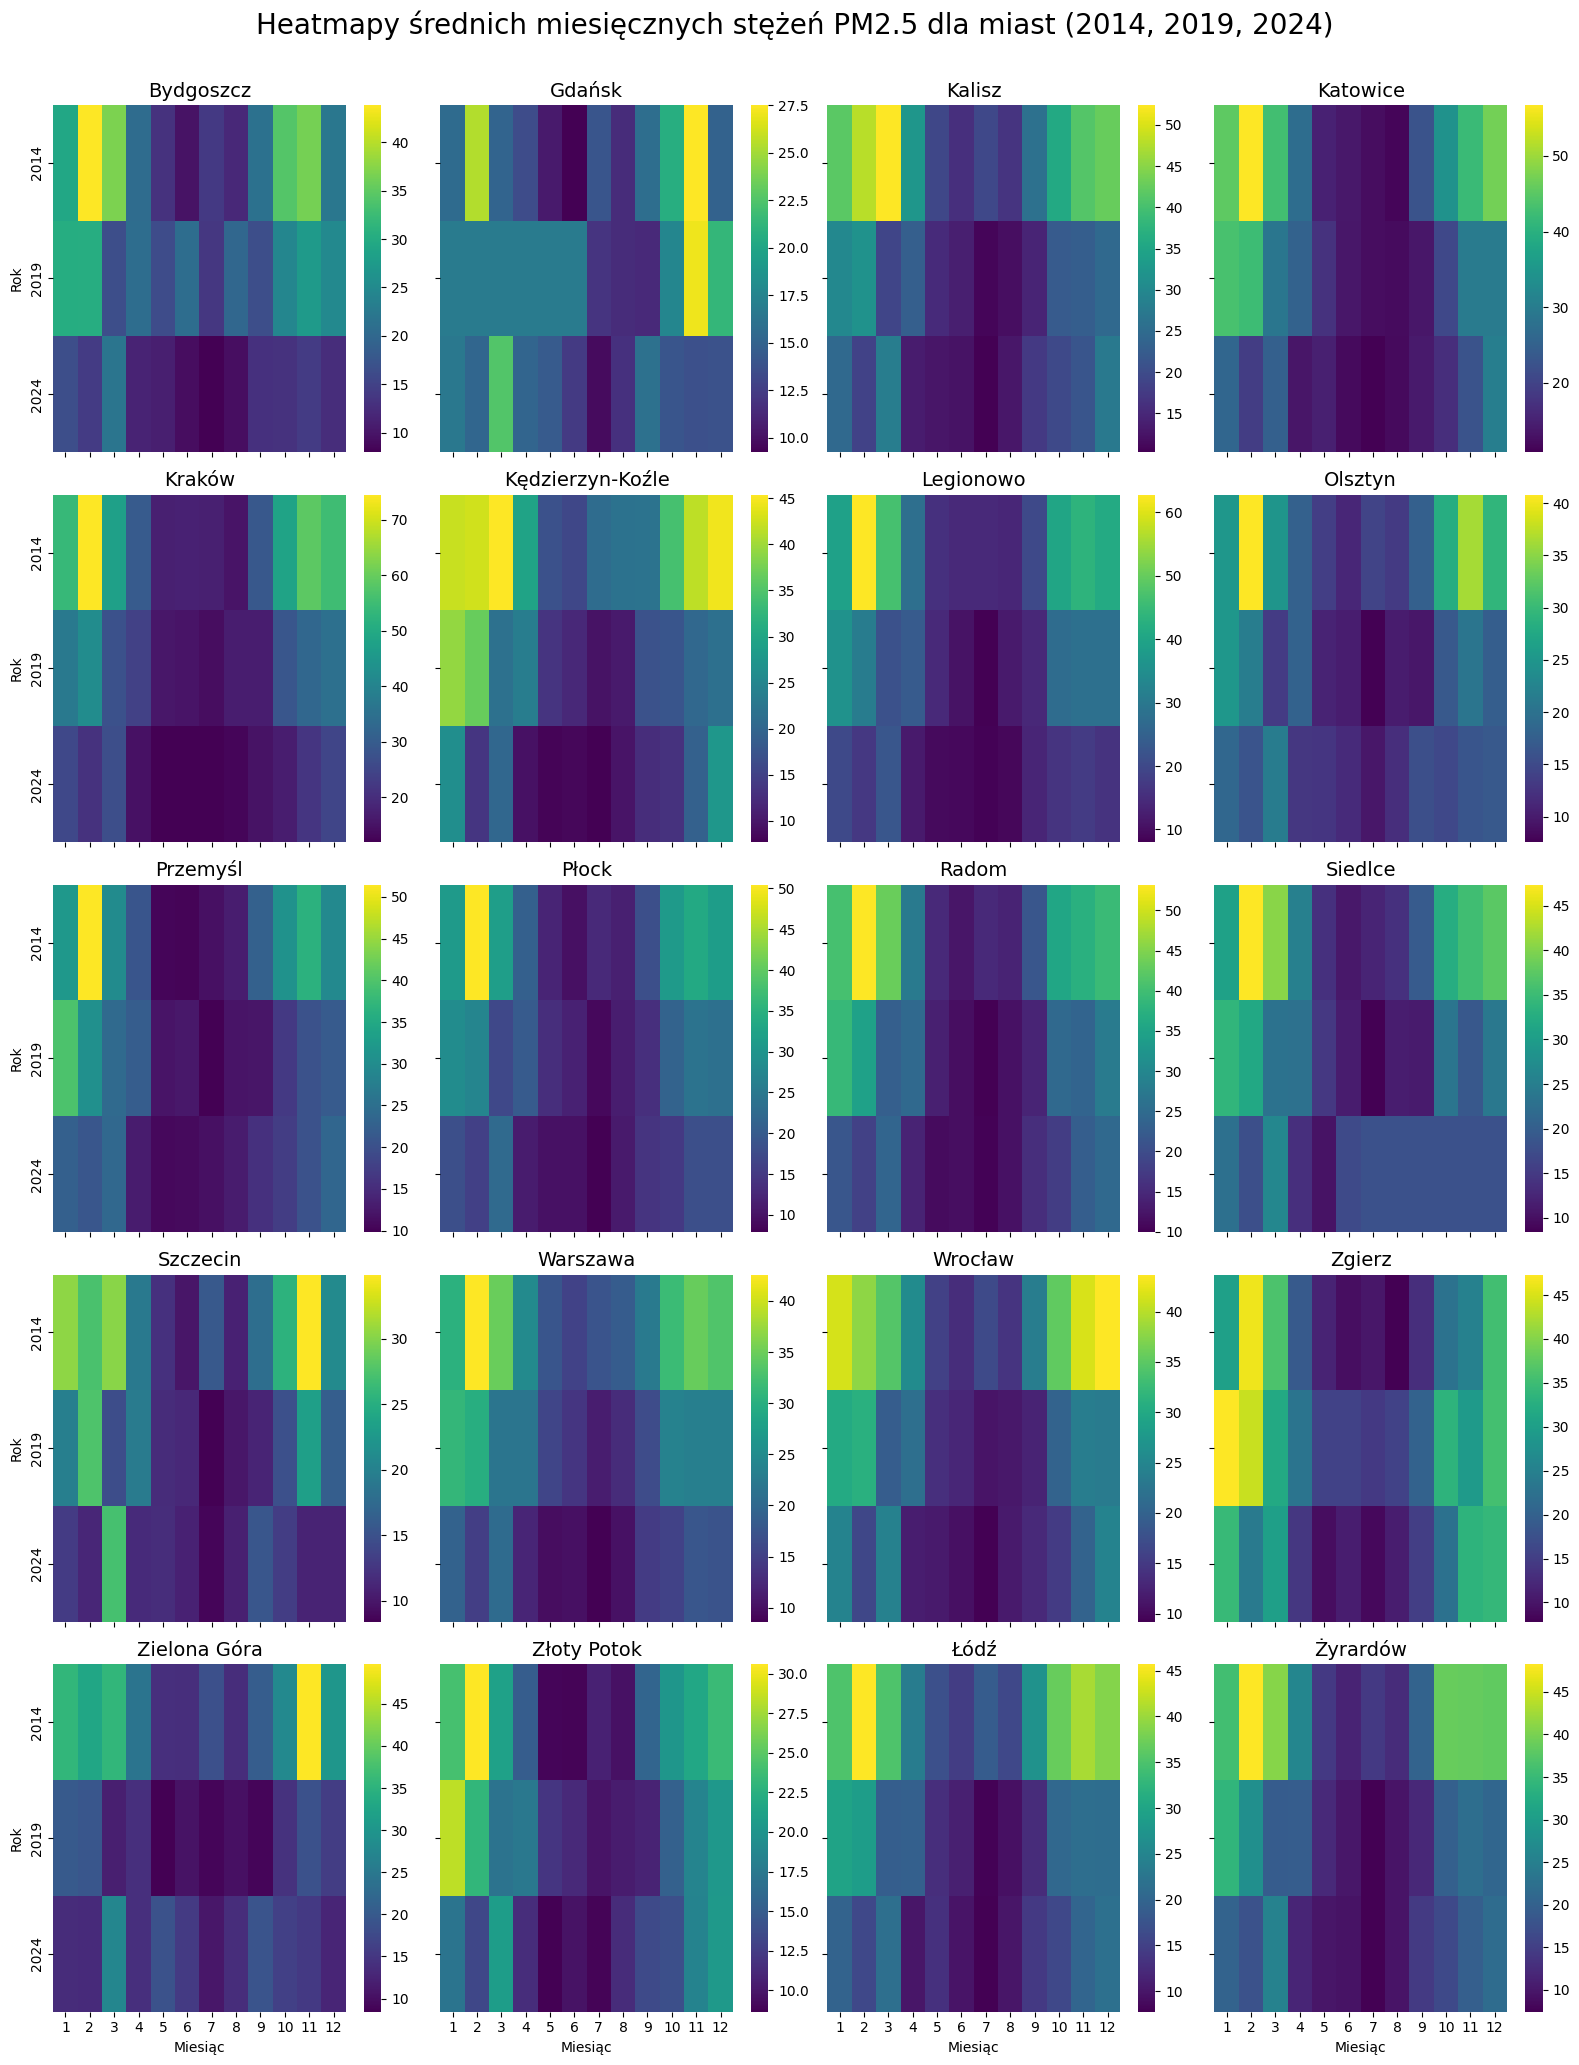

In [26]:
import seaborn as sns

# Tworzymy FacetGrid, gdzie każdy panel to jedno miasto
g = sns.FacetGrid(city_monthly_avg, col="City", col_wrap=4, height=4)

# Mapujemy heatmapę na każdy panel
g.map_dataframe(
    lambda data, color: sns.heatmap(
        data.pivot(index='Year', columns='Month', values='PM25_Value'),
        cmap='viridis'
    )
)

g.set_titles("{col_name}", size=14)
g.set_axis_labels("Miesiąc", "Rok")
g.figure.suptitle('Heatmapy średnich miesięcznych stężeń PM2.5 dla miast (2014, 2019, 2024)', size=20, y=1.03)

plt.show()

## Interpretacja zadania 3-ego
Z tego wykresu jasno widać, że ogólna sytuacja z zanieczyszceniem PM2.5 ulega poprawieniu - widać to min. w Warszawie, Katowicach czy Szczecinie. Są jednak wyjątki, w Siedlcach nastąpiło znaczne pogorszenie warunków, a w Zgierzu także było więcej dni przekraczających normy. Ogólnie średnio widzimy mimo wszystko, że rok 2014 był najgorszy pod tym względem. 

Można zaobserwować również podobne trendy do tych wyłaniających się z poprzedniego zadania. Dla większości miast stężenia cząstek PM2.5 są najwyższe od września do kwietnia. Zmniejszają się one również w kolejnych rozpatrywanych co 5 latach. Z trendów tych najbardziej wyłamuje się Zgierz w którym stężenia wzrosły między rokiem 2014 a 2019 i pozostały relatywnie wysokie w roku 2024.

# Zad 4
## Dni z przekroczeniem normy (WHO)
Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

In [31]:
# Norma dobowa WHO dla PM2.5
WHO_NORM = 15

# Obliczamy średnie dobowe dla każdej stacji i roku
daily_means = {}
for year, df in dfs.items():
    daily_means[year] = df.resample('D').mean()

# Liczymy dni z przekroczeniem normy
exceeding_days = {}
for year, df_daily in daily_means.items():
    exceeding_days[year] = (df_daily > WHO_NORM).sum()

# Konwertujemy wyniki do DataFrame dla łatwiejszej analizy
exceeding_df = pd.DataFrame(exceeding_days)
exceeding_df = exceeding_df.reset_index()

print("Liczba dni z przekroczeniem normy:")
display(exceeding_df.head())

Liczba dni z przekroczeniem normy:


,City,Station_Code,2014,2019,2024
0,Wrocław,DsWrocAlWisn,274,181,136
1,Bydgoszcz,KpBydPlPozna,240,243,105
2,Łódź,LdLodzCzerni,300,186,128
3,Zgierz,LdZgieMielcz,191,265,199
4,Zielona Góra,LuZielKrotka,260,106,150


In [32]:
# Wybieramy 3 stacje z najmniejszą i 3 z największą liczbą dni z przekroczeniem w 2024
exceeding_2024 = exceeding_df.sort_values(by=2024)

# 3 stacje z najmniejszą liczbą dni
bottom_3_stations = exceeding_2024.head(3)
# 3 stacje z największą liczbą dni
top_3_stations = exceeding_2024.tail(3)

selected_stations = pd.concat([bottom_3_stations, top_3_stations])
selected_station_codes = selected_stations['Station_Code'].tolist()

print("3 stacje z najmniejszą liczbą dni z przekroczeniem normy w 2024:")
display(bottom_3_stations)
print("\n3 stacje z największą liczbą dni z przekroczeniem normy w 2024:")
display(top_3_stations)

3 stacje z najmniejszą liczbą dni z przekroczeniem normy w 2024:


,City,Station_Code,2014,2019,2024
21,Szczecin,ZpSzczAndrze,200,116,72
12,Warszawa,MzWarWokalna,244,170,102
1,Bydgoszcz,KpBydPlPozna,240,243,105



3 stacje z największą liczbą dni z przekroczeniem normy w 2024:


,City,Station_Code,2014,2019,2024
17,Katowice,SlKatoKossut,259,237,185
3,Zgierz,LdZgieMielcz,191,265,199
10,Siedlce,MzSiedKonars,246,206,287


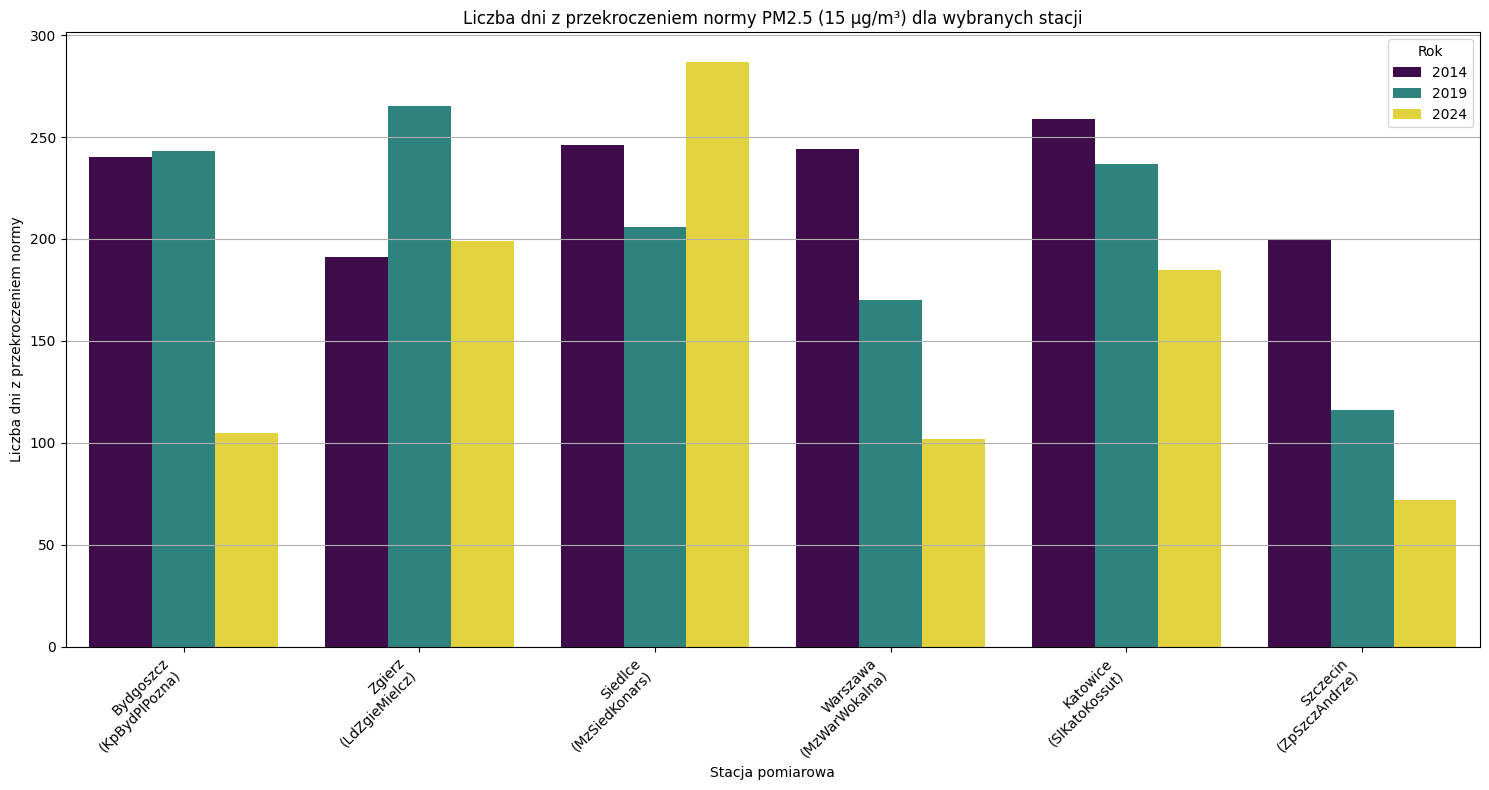

In [29]:
plot_data = exceeding_df[exceeding_df['Station_Code'].isin(selected_station_codes)]

# Przekształcamy dane do formatu 'long'
plot_data_long = plot_data.melt(
    id_vars=['City', 'Station_Code'],
    value_vars=[2014, 2019, 2024],
    var_name='Year',
    value_name='Exceeding_Days'
)

# Tworzymy etykiety dla osi X łącząc miasto i kod stacji
plot_data_long['Station_Label'] = plot_data_long['City'] + '\n(' + plot_data_long['Station_Code'] + ')'

# Rysowanie wykresu
plt.figure(figsize=(15, 8))
sns.barplot(
    data=plot_data_long,
    x='Station_Label',
    y='Exceeding_Days',
    hue='Year',
    palette='viridis'
)

plt.title('Liczba dni z przekroczeniem normy PM2.5 (15 µg/m³) dla wybranych stacji')
plt.xlabel('Stacja pomiarowa')
plt.ylabel('Liczba dni z przekroczeniem normy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Rok')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## Interpretacja zadania 4-ego 
W 2014 różnice między miastami były znacznie mniejsze. Najmniej dni w których została przekroczona 
norma emisji (poniej 200) w wybranych miast miał wtedy Zgierz a najwięcej Katowice (ponad 250). Obraz ten zmienia się w 2024, gdzie różnica pomiędzy Siedlcami a Szczecinem wyniosła już około 200 dni. Z uwagi na zaobserowany już w poprzednich zadaniach spadek emisji w większości miast sytuacja na przestrzeni 10 lat uległa zmianie. Dwa z trzech miast o nawyższej liczbie dni z przkroczoną normą w 2024 znotowały ich wzrost na przestrzeni 10 lat, natomiast w trzecim przypadku (Katowice), wynik ten można przypisać wysokiemu efektowi bazy. W przypadku najlepiej wypadających miast w 2014 liczba zanieczyszczonych dni nie była dużo większa (maksymalnie ~60) od pozostałych. Relatywny sukces można przypisać, więc raczej spadkom emisji PM2.5, potencjanie związanym np. z wysiłkami termomodernizacyjnymi.